Getting started
------

In [33]:
# import libraries
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
%matplotlib inline


<ipython-input-33-ee92a3ff1352>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [34]:
train = pd.read_csv('train.csv')
PID = train['PassengerId']
test = pd.read_csv('test.csv')

In [35]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Initial Preprocess
-----


In [36]:
pGroup = PID.str.extract('([0-9]{4})')[0]
pNum = PID.str.extract('_([0-9]{2})')[0]

In [37]:
gr = {}
group = []

for s in train['PassengerId']:
    if s[:4] not in gr.keys():
        gr[s[:4]] = 1
    else:
        gr[s[:4]] = gr[s[:4]] + 1

for s in train['PassengerId']:
    group.append(gr[s[:4]])
train['Group_Memmbers'] = group

gr = {}
group = []

for s in test['PassengerId']:
    if s[:4] not in gr.keys():
        gr[s[:4]] = 1
    else:
        gr[s[:4]] = gr[s[:4]] + 1

for s in test['PassengerId']:
    group.append(gr[s[:4]])
test['Group_Memmbers'] = group

In [38]:
split_cabin = train['Cabin'].str.split('/', expand = True)

train['Deck'] = split_cabin[0]
train['Num'] = split_cabin[1]
train['Card'] = split_cabin[2]
train.drop('Cabin', axis = 1, inplace = True)


split_cabin = test['Cabin'].str.split('/', expand = True)
test['Deck'] = split_cabin[0]
test['Num'] = split_cabin[1]
test['Card'] = split_cabin[2]
test.drop('Cabin', axis = 1, inplace = True)

In [39]:
train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

Data Analysis
------

In [40]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_Memmbers,Deck,Num,Card
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,A,98,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,1,G,1499,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,1,G,1500,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,2,E,608,S


In [41]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_Memmbers
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,2.035546
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,1.596347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,3.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [42]:
train['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

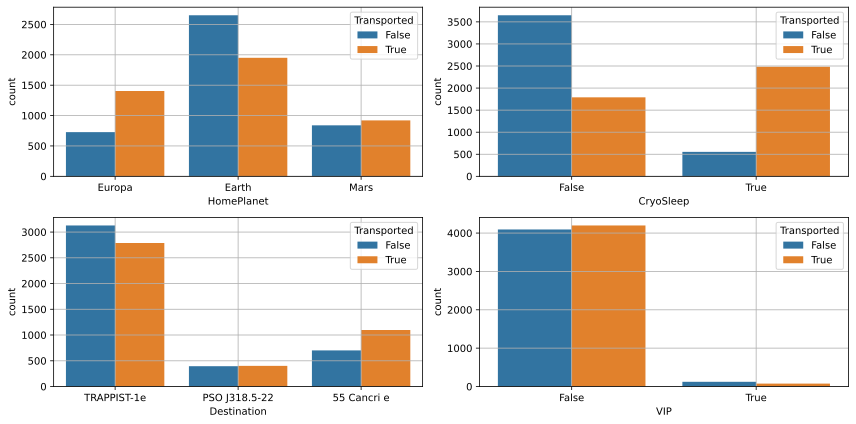

In [43]:
column = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig, ax = plt.subplots(2,2,figsize=(12,6), tight_layout = True)
num = 0
for i in range(2):
  for j in range(2):
    sns.countplot(train, x =column[2*i + j], hue='Transported' , ax =ax[i][j] )
    ax[i][j].grid()

<Axes: >

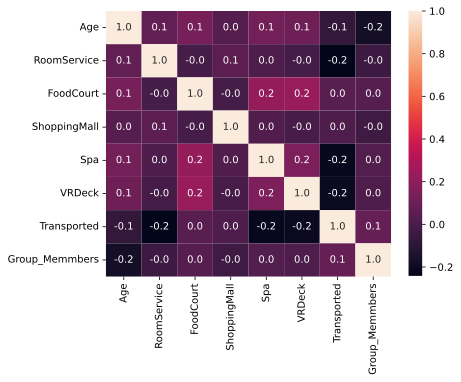

In [44]:
sns.heatmap(train.select_dtypes(include=['int', 'float', 'bool']).corr(), annot=True, fmt=".1f")
# train.select_dtypes(include=['int', 'float'])

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>],
       [<Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>],
       [<Axes: title={'center': 'Group_Memmbers'}>, <Axes: >, <Axes: >]],
      dtype=object)

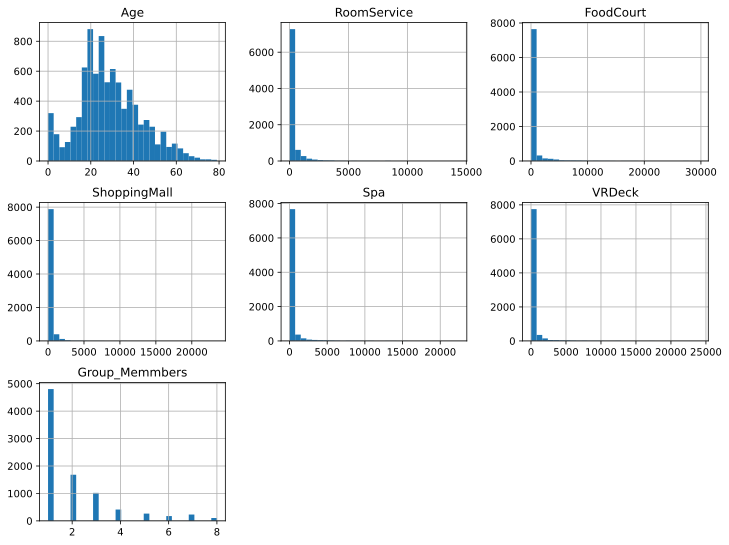

In [45]:
train.hist(figsize=(12,9), bins=30)

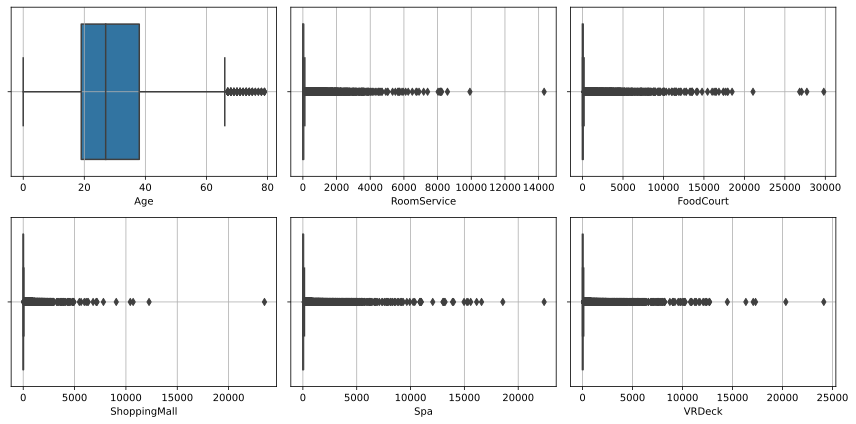

In [46]:
column = train.select_dtypes(['int','float']).drop('Group_Memmbers', axis = 1).columns
fig, ax = plt.subplots(2,3,figsize=(12,6), tight_layout = True)
num = 0
for i in range(2):
  for j in range(3):
    sns.boxplot(train,x = train[column[i*3+j]] , ax =ax[i][j] )
    ax[i][j].grid()
    # print(i*3+j)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     8693 non-null   object 
 1   HomePlanet      8492 non-null   object 
 2   CryoSleep       8476 non-null   object 
 3   Destination     8511 non-null   object 
 4   Age             8514 non-null   float64
 5   VIP             8490 non-null   object 
 6   RoomService     8512 non-null   float64
 7   FoodCourt       8510 non-null   float64
 8   ShoppingMall    8485 non-null   float64
 9   Spa             8510 non-null   float64
 10  VRDeck          8505 non-null   float64
 11  Transported     8693 non-null   bool   
 12  Group_Memmbers  8693 non-null   int64  
 13  Deck            8494 non-null   object 
 14  Num             8494 non-null   object 
 15  Card            8494 non-null   object 
dtypes: bool(1), float64(6), int64(1), object(8)
memory usage: 1.0+ MB


In [48]:
train.isna().sum()

PassengerId         0
HomePlanet        201
CryoSleep         217
Destination       182
Age               179
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Group_Memmbers      0
Deck              199
Num               199
Card              199
dtype: int64

In [49]:
train.isna().sum()/len(train)

PassengerId       0.000000
HomePlanet        0.023122
CryoSleep         0.024963
Destination       0.020936
Age               0.020591
VIP               0.023352
RoomService       0.020821
FoodCourt         0.021051
ShoppingMall      0.023927
Spa               0.021051
VRDeck            0.021627
Transported       0.000000
Group_Memmbers    0.000000
Deck              0.022892
Num               0.022892
Card              0.022892
dtype: float64

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     4277 non-null   object 
 1   HomePlanet      4190 non-null   object 
 2   CryoSleep       4184 non-null   object 
 3   Destination     4185 non-null   object 
 4   Age             4186 non-null   float64
 5   VIP             4184 non-null   object 
 6   RoomService     4195 non-null   float64
 7   FoodCourt       4171 non-null   float64
 8   ShoppingMall    4179 non-null   float64
 9   Spa             4176 non-null   float64
 10  VRDeck          4197 non-null   float64
 11  Group_Memmbers  4277 non-null   int64  
 12  Deck            4177 non-null   object 
 13  Num             4177 non-null   object 
 14  Card            4177 non-null   object 
dtypes: float64(6), int64(1), object(8)
memory usage: 501.3+ KB


In [51]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_Memmbers
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,2.035546
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,1.596347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,3.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


Split Data
------


In [52]:
PID2 = test['PassengerId']
train.drop('PassengerId', axis=1, inplace = True)
test.drop('PassengerId', axis=1, inplace = True)

In [53]:
X = train.drop('Transported', axis = 1)
Y = train['Transported']

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.1, random_state = 20)

Clean Data
---------

In [55]:
train['VIP'].astype('bool')
train['CryoSleep'].astype('bool')

test['VIP'].astype('bool')
test['CryoSleep'].astype('bool')

0        True
1       False
2        True
3       False
4       False
        ...  
4272     True
4273    False
4274     True
4275    False
4276     True
Name: CryoSleep, Length: 4277, dtype: bool

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8492 non-null   object 
 1   CryoSleep       8476 non-null   object 
 2   Destination     8511 non-null   object 
 3   Age             8514 non-null   float64
 4   VIP             8490 non-null   object 
 5   RoomService     8512 non-null   float64
 6   FoodCourt       8510 non-null   float64
 7   ShoppingMall    8485 non-null   float64
 8   Spa             8510 non-null   float64
 9   VRDeck          8505 non-null   float64
 10  Transported     8693 non-null   bool   
 11  Group_Memmbers  8693 non-null   int64  
 12  Deck            8494 non-null   object 
 13  Num             8494 non-null   object 
 14  Card            8494 non-null   object 
dtypes: bool(1), float64(6), int64(1), object(7)
memory usage: 959.4+ KB


In [57]:
 x_train.select_dtypes(include=['int', 'float', 'bool']).columns.tolist()

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group_Memmbers']

In [58]:
x_train['Num'] = x_train['Num'].fillna(value = x_train['Num'].median())
x_train['Num']= x_train['Num'].astype('int64')

numerical_columns = x_train.select_dtypes(include=['int', 'float', 'bool']).columns.tolist()
for nu in numerical_columns:
    x_train[nu] = x_train[nu].fillna(value = x_train[nu].mean())

###################################################################################
x_val['Num'] = x_val['Num'].fillna(value = x_train['Num'].median())
x_val['Num']= x_val['Num'].astype('int64')

for nu in numerical_columns:
    x_val[nu] = x_val[nu].fillna(value = x_train[nu].mean())

###################################################################################
test['Num'] = test['Num'].fillna(value = x_train['Num'].median())
test['Num']= test['Num'].astype('int64')

for nu in numerical_columns:
    test[nu] = test[nu].fillna(value = x_train[nu].mean())

In [59]:
categorial_columns = x_train.select_dtypes(include=['object']).columns.tolist()

for cc in categorial_columns:
    x_train[cc] = x_train[cc].fillna(value = x_train[cc].mode())

for cc in categorial_columns:
    x_val[cc] = x_val[cc].fillna(value = x_train[cc].mode())


for cc in categorial_columns:
    test[cc] = test[cc].fillna(value = x_train[cc].mode())

In [60]:
x_train = pd.concat([x_train, pd.get_dummies(x_train[categorial_columns], drop_first = True, dtype = 'bool') ], axis = 1)
x_train.drop(categorial_columns, axis=1, inplace = True)

x_val = pd.concat([x_val, pd.get_dummies(x_val[categorial_columns], drop_first = True, dtype = 'bool') ], axis = 1)
x_val.drop(categorial_columns, axis=1, inplace = True)

test = pd.concat([test, pd.get_dummies(test[categorial_columns], drop_first = True, dtype = 'bool') ], axis = 1)
test.drop(categorial_columns, axis=1, inplace = True)

Create Model
------------

In [61]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

x_val = sc.transform(x_val)
test = sc.transform(test)

In [62]:
from sklearn.svm import SVC
SV = SVC(random_state=20, C = 0.1).fit(x_train,y_train)
SVCpred = SV.predict(x_val)
accuracy_score(SVCpred,y_val)

0.774712643678161

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
#Create a dictionary and fill out some parameters for kernels, C and gamma
param_grid = [
  { 'kernel': ['linear']},
   {'gamma': [0.1,0.01,0.001], 'kernel': ['poly','rbf', 'sigmoid']},
 ]
grid = GridSearchCV(SVC(random_state=20),param_grid,refit=True,verbose=2)

# fitting the model for grid search
grid.fit(x_train, y_train)


In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [71]:
SV = SVC(C = 10, gamma = 0.01, kernel = 'rbf').fit(x_train,y_train)
SVCpred = SV.predict(x_val)
accuracy_score(SVCpred,y_val)

0.8149425287356322

In [68]:
Mpred = SV.predict(test)

In [69]:
sub = {'PassengerId':PID2, 'Transported':Mpred}
sub = pd.DataFrame(data = sub)
sub.to_csv('submit.csv',index=False)